# Generation of Tables / Figures for Research Paper

## 1. Getting Runs
Select sweep, order and filter runs to get top 10 runs based on assumed 15-run-sweeps.

In [92]:
import wandb

# specify params for table generation 
sweep_path = 'niware/dp_benchmark/0cud9g6o'
baseline_run_path = 'niware/baseline/3kl428qm'
model_name = "W10D10\\\ Dense Model"
num_params = "100K" # this can't be extracted

api = wandb.Api()

dp_sweep = api.sweep(sweep_path)
baseline_run = api.run(baseline_run_path)
summary_list = [] 
config_list = [] 
name_list = [] 
for run in dp_sweep.runs: 
    # run.summary are the output key/values like accuracy.
    # We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict) 

    # run.config is the input metrics.
    # We remove special values that start with _.
    config = {k:v for k,v in run.config.items() if not k.startswith('_')}
    config['path'] = run.path
    config_list.append(config) 

    # run.name is the name of the run.
    name_list.append(run.name)       

import pandas as pd 
summary_df = pd.DataFrame.from_records(summary_list) 
config_df = pd.DataFrame.from_records(config_list) 
name_df = pd.DataFrame({'name': name_list}) 
all_df = pd.concat([name_df, config_df,summary_df], axis=1)
#print(all_df.columns.tolist())

# important cols for this experiment
important_cols = [
    "name",
    "_timestamp",
    "val_acc",
    "val_loss",
    "epoch",
    "L2_clip",
    "global grad norm",
    "spent_epsilon",
    "train_loss",
    "trainer/global_step",
    "path",
]
# get important columns only
final_df = all_df.loc[:, important_cols]
# only consider 15 first runs in sweep (in case there are more in sweep)
final_df = final_df.sort_values('_timestamp', ascending=True)[:15]
# get top 10
final_df = final_df.sort_values('val_acc', ascending=False)[:10]

#final_df.to_csv("project.csv")

## Table 1 - Performance Info
Extract and process all information and directly generate latex table row.<br>
```Model | ValAcc No-DP | Mean ValAcc DP (STD DEV) | Best ValAcc [Run-Nr] Epochs```

In [93]:
# Init. final information 
table_1_assembly = {
    "model": model_name,
    "valacc_nodp": 0.000,
    "valacc_dp_avg": 0.000,
    "valacc_dp_std": 0.000,
    "valacc_dp_best": 0.000,
    "best_num": 0.000,
    "best_epochs": 0.000,
}

In [94]:
import re

# DP-Sweep runs
table_1_assembly["valacc_dp_best"] = final_df.iloc[0]["val_acc"] # we ordered the runs
table_1_assembly["valacc_dp_avg"] = final_df["val_acc"].mean()
table_1_assembly["valacc_dp_std"] = final_df["val_acc"].std()
table_1_assembly["best_epochs"] = final_df.iloc[0]["epoch"]
# wandb sweeps are always called 'adjective-sweep-Nr.' - we extract the number
table_1_assembly["best_num"] = float(
    re.findall(
        "\d+", 
        final_df.iloc[0]["name"]
    )[0]
) # regex to extract numbers

# Baseline
table_1_assembly["valacc_nodp"] = baseline_run.summary["val_acc"]

print(table_1_assembly)

{'model': 'W10D10\\\\ Dense Model', 'valacc_nodp': 0.6530057191848755, 'valacc_dp_avg': 0.4746785879135132, 'valacc_dp_std': 0.007263291879589248, 'valacc_dp_best': 0.48101648688316345, 'best_num': 6.0, 'best_epochs': 25}


## Table 2 - Extra Info
Extract and process all information and directly generate latex table row.<br>
```Model | GGN no-DP | GGN DP (STD DEV) | Best Run GGN | Best Run L2 | #Params```

In [95]:
# Init. final information 
table_2_assembly = {
    "model": model_name,
    "ggn_nodp": 0.000,
    "ggn_dp_avg": 0.000,
    "ggn_dp_std": 0.000,
    "ggn_dp_best": 0.000,
    "L2_clip": 0.000,
    "params": num_params,
}

In [96]:
# not used at the moment
def exp_moving_average(ts, alpha=0.01): 
    """
        Takes in an array of floats and a factor between [0,1] 
        and returns the exponentially smoothed timeseries as array
    """
    smoothed_ts = []
    smoothed_ts.append(ts[0])
    for t in range(1, len(ts)): 
        smoothed_ts.append(
            (1-alpha)*smoothed_ts[t-1] + alpha*ts[t]
        )
    return smoothed_ts

In [101]:
from tqdm import tqdm

sweep_size = 10
alpha = 0.01
ggn_final_values = []

for i in tqdm(range(sweep_size)):
    # get run from ordered and filtered runs
    dp_run_name = "/".join(final_df.iloc[i]['path'])
    dp_run = api.run(dp_run_name)

    # get complete GGN history
    dp_run_history = dp_run.scan_history(keys=['global grad norm'])
    ggn_ts = pd.Series([row["global grad norm"] for row in dp_run_history])

    # apply exponential moving mean smoothing
    ggn_ts_smoothed_pandas = ggn_ts.ewm(alpha=alpha).mean()
    # ggn_ts_smoothed_custom = pd.Series(exp_moving_average(ggn_ts.tolist(), alpha))

    # save last timestep (can be different depending on number of epochs of run)
    ggn_final_values.append(ggn_ts_smoothed_pandas.iloc[-1])

ggn_final_values = pd.Series(ggn_final_values)
ggn_smoothed_mean = ggn_final_values.mean()
ggn_raw_mean = final_df['global grad norm'].mean()

print(f"ggn_smoothed_mean: {ggn_smoothed_mean}")
print(f"ggn_raw_mean: {ggn_raw_mean}")

# save most important params
table_2_assembly["ggn_dp_avg"] = ggn_final_values.mean()
table_2_assembly["ggn_dp_std"] = ggn_final_values.std()
table_2_assembly["ggn_dp_best"] = ggn_final_values.iloc[0] # we ordered the runs
table_2_assembly["L2_clip"] = final_df.iloc[0]["L2_clip"] # we ordered the runs

100%|██████████| 10/10 [00:03<00:00,  2.57it/s]

ggn_smoothed_mean: 6.648743541673899
ggn_raw_mean: 0.13359409583772783


In [98]:
# get no-DP baseline GGN
# get complete GGN history
baseline_run_history = baseline_run.scan_history(keys=['global grad norm'])
ggn_nodp_ts = pd.Series([row["global grad norm"] for row in baseline_run_history])

# apply exponential moving average smoothing
table_2_assembly["ggn_nodp"] = ggn_nodp_ts.ewm(alpha=alpha).mean().iloc[-1]

print(f"ggn_nodp: {table_2_assembly['ggn_nodp']}")

ggn_nodp: 4.07407767244986


### Generation of Latex Table Rows

In [99]:
# Assemble final table rows

# Output: Model | ValAcc No-DP | Mean ValAcc DP (STD DEV) | Best ValAcc [Run-Nr] Epochs
print("*** TABLE 1 ***")
print(
    '''
    \\thead{%s} & %.3f & \\thead{%.3f\\\ (%.3f)} & \\thead{%.3f [%d]\\\ %d} \\\\
    '''%(
        table_1_assembly["model"],
        table_1_assembly["valacc_nodp"], 
        table_1_assembly["valacc_dp_avg"], 
        table_1_assembly["valacc_dp_std"], 
        table_1_assembly["valacc_dp_best"], 
        int(table_1_assembly["best_num"]), 
        int(table_1_assembly["best_epochs"]),
    )
)

# Output: Model | GGN no-DP | GGN DP (STD) | Best Run GGN | Best Run L2 | #Params
print("*** TABLE 2 ***")
print(
    '''
    \\thead{%s} & %.3f & \\thead{%.3f\\\ (%.3f)} & %.3f & %.3f & %s \\\\
    '''%(
        table_2_assembly["model"],
        table_2_assembly["ggn_nodp"], 
        table_2_assembly["ggn_dp_avg"], 
        table_2_assembly["ggn_dp_std"], 
        table_2_assembly["ggn_dp_best"], 
        table_2_assembly["L2_clip"], 
        table_2_assembly["params"]
    )
)

*** TABLE 1 ***

    \thead{W10D10\\ Dense Model} & 0.653 & \thead{0.475\\ (0.007)} & \thead{0.481 [6]\\ 25} \\
    
*** TABLE 2 ***

    \thead{W10D10\\ Dense Model} & 4.074 & \thead{6.649\\ (0.112)} & 6.656 & 9.893 & 100K \\
    


# Experiments

In [141]:
# specify params for table generation 
sweep_path = 'niware/dp_benchmark/zaoiuche'
baseline_run_path = 'niware/baseline/z9w1nsaf'

import wandb
api = wandb.Api()

dp_sweep = api.sweep(sweep_path)
baseline_run = api.run(baseline_run_path)
summary_list = [] 
config_list = [] 
name_list = [] 
for run in dp_sweep.runs: 
    # run.summary are the output key/values like accuracy.
    # We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict) 

    # run.config is the input metrics.
    # We remove special values that start with _.
    config = {k:v for k,v in run.config.items() if not k.startswith('_')}
    config['path'] = run.path
    config_list.append(config) 

    # run.name is the name of the run.
    name_list.append(run.name)       

import pandas as pd 
summary_df = pd.DataFrame.from_records(summary_list) 
config_df = pd.DataFrame.from_records(config_list) 
name_df = pd.DataFrame({'name': name_list}) 
all_df = pd.concat([name_df, config_df,summary_df], axis=1)
#print(all_df.columns.tolist())

# important cols for this experiment
important_cols = [
    "name",
    "_timestamp",
    "val_acc",
    "val_loss",
    "epoch",
    "L2_clip",
    "global grad norm",
    "spent_epsilon",
    "train_loss",
    "trainer/global_step",
    "path",
]
# get important columns only
final_df = all_df.loc[:, important_cols]
# only consider 15 first runs in sweep (in case there are more in sweep)
final_df = final_df.sort_values('_timestamp', ascending=True)[:15]
# get top 10
final_df = final_df.sort_values('val_acc', ascending=False)[:10]

#final_df.to_csv("project.csv")

In [156]:
run_nr = 9 # 0-9
dp_run_name = "/".join(final_df.iloc[run_nr]['path'])
print(dp_run_name)
dp_run = api.run(dp_run_name)

niware/dp_benchmark/po1lacc1


In [157]:
# get complete GGN history
dp_run_history = dp_run.scan_history(keys=['global grad norm'])
ggn_ts = pd.Series([row["global grad norm"] for row in dp_run_history])

# apply exponential moving average smoothing
alpha = 0.01
ggn_ts_smoothed_pandas = ggn_ts.ewm(alpha=alpha).mean()
ggn_ts_smoothed_custom = pd.Series(exp_moving_average(ggn_ts.tolist(), alpha))

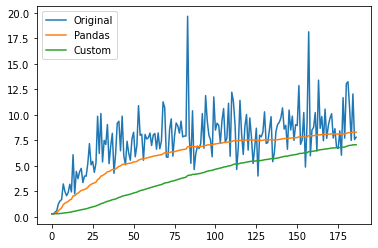

In [158]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
ggn_ts.plot()
ggn_ts_smoothed_pandas.plot()
ggn_ts_smoothed_custom.plot()
ax.legend(["Original", "Pandas", "Custom"])

In [159]:
ggn_ts_smoothed_pandas.iloc[-1]

8.291449196700098

In [ ]:
# Assemble final table
run_assembly = {
    "ggn_nodp": 3.893,
    "ggn_dp_avg": 8.198,
    "ggn_dp_std": 1.666,
    "ggn_dp_best": 9.884,
    "l2": 9.884,
    "params": 0.000,
}

print(
    '''
    \\begin{tabular}{||c c c c c c||} 
    \hline
    \\thead{Model} & \\thead{GGN no-DP} & \\thead{GGN DP\\\ (Std Dev)} & \\thead{Best Run\\\ GGN} & \\thead{Best Run\\\ L2 Clip} & \\thead{Params}\\\ [0.5ex] 
    \hline\hline
    \\thead{W10D10\\\ Residual Model} & %.3f & \\thead{%.3f\\\ (%.3f)} & %.3f & %.3f & %.3f \\\\
    \\thead{W50D10\\\ Residual Model} & 4.676 & \\thead{13.468\\\ (3.370)} & 8.573 & 8.573 & 447K\\\\
    \\thead{W10D80\\\ Residual Model} & 5.044 & \\thead{18.107\\\ (4.353)} & 7.379 & 7.379 & 143K \\\\
    \\thead{W50D80\\\ Residual Model} & 6.777 & \\thead{62.783\\\ (100.42)} & 3.911 & 3.911 & 1.5M \\\ [1ex] 
    \hline
    \end{tabular}
    '''%(
        run_assembly["ggn_nodp"], 
        run_assembly["ggn_dp_avg"], 
        run_assembly["ggn_dp_std"], 
        run_assembly["ggn_dp_best"], 
        run_assembly["l2"], 
        run_assembly["params"]
    )
)